## NoisyDQN

主要改动是在原本的Q网络中，直接对网络参数增加噪声以增加探索性，最直接的是给每个参数都添加一个高斯噪声。此处注意在每个回合中，只在最初添加一次噪声，后续都使用相同的网络进行价值估计，到下一个回合再重新添加噪声，这是为了保证同一回合内网络的价值估计是一致的，即对同一个状态同一个动作的估计是一样的，而使用$\epsilon$-贪心的方式来增加探索性，即使给定相同的状态，也未必会采取相同的动作，这是因为$\epsilon$-贪心具有一定的随机性。噪音网络虽然也有随机性，但在一个回合内是确定的，这称为依赖状态的探索（state-dependent exploration）

## 1.1 定义模型
模型中主要改动的点是给模型参数加上噪声，这里将模型参数设为均值为$\mu$，方差为$\sigma$的高斯分布，加噪即为改变模型的方差，此处生成噪声用了一些小技巧，不是直接生成output_dim x input_dim大小的噪声矩阵，而是生成output_dim和input_dim两个向量，再将两个向量做外积最终得到output_dim x input_dim的噪声矩阵，这样在运算过程中生成和保存的数量都大大减少而且仅多一步外积运算。另外注意self.training是nn.Module中继承的属性，在调用train()时会被设置成True，调用eval则会被设置成False，不需要显式设置

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
class NoisyLinear(nn.Module):
    def __init__(self, input_dim, output_dim, std_init=0.4):
        super(NoisyLinear, self).__init__()
        
        self.input_dim  = input_dim
        self.output_dim = output_dim
        self.std_init     = std_init
        
        self.weight_mu    = nn.Parameter(torch.FloatTensor(output_dim, input_dim))
        self.weight_sigma = nn.Parameter(torch.FloatTensor(output_dim, input_dim))
        self.register_buffer('weight_epsilon', torch.FloatTensor(output_dim, input_dim))
        
        self.bias_mu    = nn.Parameter(torch.FloatTensor(output_dim))
        self.bias_sigma = nn.Parameter(torch.FloatTensor(output_dim))
        self.register_buffer('bias_epsilon', torch.FloatTensor(output_dim))
        
        self.reset_parameters()
        self.reset_noise()
    
    def forward(self, x):
        if self.training: 
            weight = self.weight_mu + self.weight_sigma.mul(self.weight_epsilon)
            bias   = self.bias_mu   + self.bias_sigma.mul(self.bias_epsilon)
        else:
            weight = self.weight_mu
            bias   = self.bias_mu
            
        return F.linear(x, weight, bias)
    
    def reset_parameters(self):
        mu_range = 1 / math.sqrt(self.weight_mu.size(1))
        
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.weight_sigma.size(1)))
        
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.bias_sigma.size(0)))
    
    def reset_noise(self):
        epsilon_in  = self._scale_noise(self.input_dim)
        epsilon_out = self._scale_noise(self.output_dim)

        self.weight_epsilon.copy_(torch.outer(epsilon_out, epsilon_in))
        self.bias_epsilon.copy_(self._scale_noise(self.output_dim))
    
    def _scale_noise(self, size):
        x = torch.randn(size)
        x = x.sign().mul(x.abs().sqrt())
        return x

class NoisyMLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(NoisyMLP, self).__init__()
        self.fc1 =  nn.Linear(input_dim, hidden_dim)
        self.noisy_fc2 = NoisyLinear(hidden_dim, hidden_dim)
        self.noisy_fc3 = NoisyLinear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.noisy_fc2(x))
        x = self.noisy_fc3(x)
        return x

    def reset_noise(self):
        self.noisy_fc2.reset_noise()
        self.noisy_fc3.reset_noise()

## 1.2 定义经验回放
经验回放首先是具有一定容量的，只有存储一定的transition网络才会更新，否则就退回到了之前的逐步更新了。另外写经验回放的时候一般需要包涵两个功能或方法，一个是push，即将一个transition样本按顺序放到经验回放中，如果满了就把最开始放进去的样本挤掉，这里就按照队列来写了。另外一个是sample，很简单就是随机采样出一个或者若干个（具体多少就是batch_size了）样本供DQN网络更新。功能讲清楚了，大家可以按照自己的想法用代码来实现，参考如下。

In [2]:
from collections import deque
import random
class ReplayBuffer(object):
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=self.capacity)
    def push(self,transitions):
        ''' 存储transition到经验回放,append在队列库的实现中是右侧放入,队列满的时候左侧的元素会被自动弹出，形成FIFO
        '''
        self.buffer.append(transitions)
    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer): # 如果批量大小大于经验回放的容量，则取经验回放的容量
            batch_size = len(self.buffer)
        if sequential: # 随机开始位置的顺序采样
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else: # 随机采样
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
    def clear(self):
        ''' 清空经验回放
        '''
        self.buffer.clear()
    def __len__(self):
        ''' 返回当前存储的量
        '''
        return len(self.buffer)

## 1.3 真·算法
此处注意每一轮结束后要重置噪声


In [3]:
import torch
import torch.optim as optim
import math
import numpy as np
import copy
class NoisyDQN:
    def __init__(self,model,memory,cfg):

        self.n_actions = cfg['n_actions']  
        self.device = torch.device(cfg['device']) 
        self.gamma = cfg['gamma'] # 奖励的折扣因子
        # e-greedy策略相关参数 这里
        self.sample_count = 0  # 用于epsilon的衰减计数
        self.epsilon = cfg['epsilon_start']
        self.sample_count = 0  
        self.epsilon_start = cfg['epsilon_start']
        self.epsilon_end = cfg['epsilon_end']
        self.epsilon_decay = cfg['epsilon_decay']
        self.batch_size = cfg['batch_size']
        self.policy_net = model.to(self.device)
        # 这里改用深拷贝创建一个新的独立网络并拥有自己独立的内存空间 
        self.target_net = copy.deepcopy(self.policy_net)
        # 原始代码，有指向同一个实例化模型的嫌疑，这里为了保险改用深拷贝
        # self.target_net = model.to(self.device)
        # 复制参数到目标网络
        # for target_param, param in zip(self.target_net.parameters(),self.policy_net.parameters()): 
            #target_param.data.copy_(param.data)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=cfg['lr']) # 优化器
        self.memory = memory # 经验回放
    def sample_action(self, state):
        ''' 采样动作
        '''
        self.sample_count += 1
        # epsilon指数衰减
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay) 
        if random.random() > self.epsilon:
            return self.predict_action(state)
        else:
            return random.randrange(self.n_actions)
    @torch.no_grad() # 不计算梯度，该装饰器效果等同于with torch.no_grad()： 这里仅仅是采样，是运行一下策略网络，不是来优化策略网络的，所以不要计算梯度
    def predict_action(self, state):
        ''' 预测动作
        '''
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        q_values = self.policy_net(state)
        action = q_values.max(1)[1].item() # choose action corresponding to the maximum q value
        return action
    def update(self):
        if len(self.memory) < self.batch_size: # 当经验回放中不满足一个批量时，不更新策略
            return
        # 从经验回放中随机采样一个批量的转移(transition) 注意此处对应着标准的四元组 加上一个done表示某一步采样是否正好结束状态
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(
            self.batch_size)
        # 将数据转换为tensor
        state_batch = torch.tensor(np.array(state_batch), device=self.device, dtype=torch.float)
        action_batch = torch.tensor(action_batch, device=self.device).unsqueeze(1)  # 转换成state一样的形状 不然就是一维的batch batch每个样本对应的动作
        reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float)  
        next_state_batch = torch.tensor(np.array(next_state_batch), device=self.device, dtype=torch.float)
        done_batch = torch.tensor(np.float32(done_batch), device=self.device)
        q_values = self.policy_net(state_batch).gather(dim=1, index=action_batch) # 计算当前状态(s_t,a)对应的Q(s_t, a)
        next_q_values = self.target_net(next_state_batch).max(1)[0].detach() # 计算下一时刻的状态(s_t_,a)对应的Q值
        # 计算期望的Q值，对于终止状态，此时done_batch[0]=1, 对应的expected_q_value等于reward
        expected_q_values = reward_batch + self.gamma * next_q_values * (1-done_batch)
        loss = nn.MSELoss()(q_values, expected_q_values.unsqueeze(1))  # 计算均方根损失
        # 优化更新模型
        self.optimizer.zero_grad()  
        loss.backward()
        # clip防止梯度爆炸
        for param in self.policy_net.parameters():  
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step() 

        ## 噪声参数重置
        self.policy_net.reset_noise()
        self.target_net.reset_noise()

## 2 定义训练

适配了新版的api（如seed的传入位置，reset的新返回值和step的新返回值），增加了测试时的录制功能，会录制一个视频来记录测试过程 

In [4]:
from gymnasium.wrappers import RecordVideo
from IPython.display import Video, display
import glob
import gymnasium as gym
import os

def train(cfg, env, agent):
    print("开始训练！")
    rewards = []
    steps = []

    # 设置动作空间seed
    if cfg.get('seed', None) is not None:
        env.action_space.seed(cfg['seed'])
        
    for i_ep in range(cfg['train_eps']):
        ep_reward = 0.0
        ep_step = 0
        # Gymnasium 的 reset 返回 (obs, info) 并在此处加入seed参数
        state, _ = env.reset(seed=cfg.get('seed', None))
        for _ in range(cfg['ep_max_steps']):
            ep_step += 1
            action = agent.sample_action(state)
            # Gymnasium 的 step 返回 5 元组
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.memory.push((state, action, reward, next_state, done))
            state = next_state
            agent.update()
            ep_reward += reward
            if done:
                break

        if (i_ep + 1) % cfg['target_update'] == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())

        steps.append(ep_step)
        rewards.append(ep_reward)
        if (i_ep + 1) % 10 == 0:
            print(f"回合：{i_ep+1}/{cfg['train_eps']}，奖励：{ep_reward:.2f}，Epislon：{agent.epsilon:.3f}")

    print("完成训练！")
    env.close()
    return {'rewards': rewards}

# 增加了录制最终测试时的场景视频并播放的功能
def test_and_record(cfg, agent, video_dir='./videos', name_prefix='dqn-test'):
    os.makedirs(video_dir, exist_ok=True)
    # 仅用于录制的环境：必须用 rgb_array
    env = gym.make(cfg['env_name'], render_mode='rgb_array')
    # 可选：设置随机种子
    seed = cfg.get('seed', None)
    if seed is not None:
        env.action_space.seed(seed)
    # 只录制最后一集
    env = RecordVideo(
        env,
        video_folder=video_dir,
        name_prefix=name_prefix,
        episode_trigger=lambda ep_id: ep_id == cfg['test_eps'] - 1
    )
    print("开始测试并录制视频！")
    rewards = []
    for i_ep in range(cfg['test_eps']):
        state, _ = env.reset(seed=seed)
        ep_reward = 0.0
        for _ in range(cfg['ep_max_steps']):
            action = agent.predict_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            ep_reward += reward
            state = next_state
            if terminated or truncated:
                break
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg['test_eps']}，奖励：{ep_reward:.2f}")
    env.close()
    print("完成测试与录制")
    # 只查找本次 name_prefix 下的 mp4，避免历史文件干扰
    mp4s = sorted(glob.glob(os.path.join(video_dir, f'{name_prefix}*.mp4')))
    if mp4s:
        print(f"视频文件：{mp4s[-1]}")
        display(Video(mp4s[-1], embed=True))
    else:
        print(f"未找到视频文件，请检查目录：{video_dir} 或确认已安装 imageio 和 imageio-ffmpeg")
    return {'rewards': rewards, 'video_path': (mp4s[-1] if mp4s else None)}


## 3 定义环境
此处因为gym包更新为gymnasium，因此需要对之前使用gym包环境定义进行一些改动

In [8]:
import gymnasium as gym
import os
# 让所有的随机种子都使用同一个数
def all_seed(env,seed = 1):
    ''' 万能的seed函数
    '''
    # 新版已经舍弃 env.seed 需要在env.reset还有env.observation_space和action_space中单独传入seed参数
    # env.seed(seed) # env config
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn 不用也可以 这里是保证100%可复现
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    # torch.backends.cudnn.enabled = False
def env_agent_config(cfg):
    env = gym.make(cfg['env_name']) # 创建环境
    if cfg['seed'] !=0:
        all_seed(env,seed=cfg['seed'])
    n_states = env.observation_space.shape[0]
    # 注意 属性n在离散动作空间的情况下才有 连续动作空间没有这个属性
    n_actions = env.action_space.n
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}")
    cfg.update({"n_states":n_states,"n_actions":n_actions}) # 更新n_states和n_actions到cfg参数中
    model = NoisyMLP(n_states, n_actions, hidden_dim = cfg['hidden_dim']) # 创建模型
    memory = ReplayBuffer(cfg['memory_capacity'])
    agent = NoisyDQN(model,memory,cfg)
    return env,agent

## 4 设置参数

In [9]:
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
def get_args():
    """ 超参数 可以自己调整超参数或使用不同的网络结构玩一下 
    """
    parser = argparse.ArgumentParser(description="hyperparameters")      
    parser.add_argument('--algo_name',default='DQN',type=str,help="name of algorithm")
    # 注意 新版gym中 改为了CartPole-v1 v0已经弃用
    parser.add_argument('--env_name',default='CartPole-v1',type=str,help="name of environment")
    parser.add_argument('--train_eps',default=90,type=int,help="episodes of training")
    parser.add_argument('--test_eps',default=20,type=int,help="episodes of testing")
    parser.add_argument('--ep_max_steps',default = 100000,type=int,help="steps per episode, much larger value can simulate infinite steps")
    parser.add_argument('--gamma',default=0.95,type=float,help="discounted factor")
    parser.add_argument('--epsilon_start',default=0.95,type=float,help="initial value of epsilon")
    parser.add_argument('--epsilon_end',default=0.01,type=float,help="final value of epsilon")
    parser.add_argument('--epsilon_decay',default=500,type=int,help="decay rate of epsilon, the higher value, the slower decay")
    parser.add_argument('--lr',default=0.0001,type=float,help="learning rate")
    parser.add_argument('--memory_capacity',default=100000,type=int,help="memory capacity")
    parser.add_argument('--batch_size',default=64,type=int)
    parser.add_argument('--target_update',default=4,type=int)
    parser.add_argument('--hidden_dim',default=256,type=int)
    parser.add_argument('--device',default='cuda',type=str,help="cpu or cuda") 
    parser.add_argument('--seed',default=10,type=int,help="seed")   
    args = parser.parse_args([])
    args = {**vars(args)}  # 转换成字典类型    
    ## 打印超参数
    print("超参数")
    print(''.join(['=']*80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("Name", "Value", "Type"))
    for k,v in args.items():
        print(tplt.format(k,v,str(type(v))))   
    print(''.join(['=']*80))      
    return args
def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,cfg, tag='train'):
    ''' 画图
    '''
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{tag}ing curve on {cfg['device']} of {cfg['algo_name']} for {cfg['env_name']}")
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()
    plt.show()

## 5 开始训练

超参数
        Name        	       Value        	        Type        
     algo_name      	        DQN         	   <class 'str'>    
      env_name      	    CartPole-v1     	   <class 'str'>    
     train_eps      	         90         	   <class 'int'>    
      test_eps      	         20         	   <class 'int'>    
    ep_max_steps    	       100000       	   <class 'int'>    
       gamma        	        0.95        	  <class 'float'>   
   epsilon_start    	        0.95        	  <class 'float'>   
    epsilon_end     	        0.01        	  <class 'float'>   
   epsilon_decay    	        500         	   <class 'int'>    
         lr         	       0.0001       	  <class 'float'>   
  memory_capacity   	       100000       	   <class 'int'>    
     batch_size     	         64         	   <class 'int'>    
   target_update    	         4          	   <class 'int'>    
     hidden_dim     	        256         	   <class 'int'>    
       device       	        cuda        	   <class

/tmp/ipykernel_2614/2887386461.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weight = self.weight_mu + self.weight_sigma.mul(torch.tensor(self.weight_epsilon))
/tmp/ipykernel_2614/2887386461.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bias   = self.bias_mu   + self.bias_sigma.mul(torch.tensor(self.bias_epsilon))


回合：10/90，奖励：24.00，Epislon：0.643
回合：20/90，奖励：15.00，Epislon：0.477
回合：30/90，奖励：10.00，Epislon：0.361
回合：40/90，奖励：11.00，Epislon：0.275
回合：50/90，奖励：21.00，Epislon：0.160
回合：60/90，奖励：44.00，Epislon：0.082
回合：70/90，奖励：47.00，Epislon：0.028
回合：80/90，奖励：315.00，Epislon：0.010
回合：90/90，奖励：299.00，Epislon：0.010
完成训练！


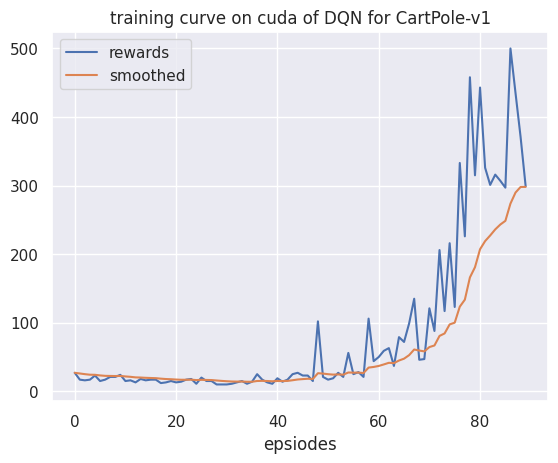

/root/shared-nvme/RL_learn/.venv/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /root/shared-nvme/RL_learn/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


开始测试并录制视频！
回合：1/20，奖励：470.00


/tmp/ipykernel_2614/2887386461.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weight = self.weight_mu + self.weight_sigma.mul(torch.tensor(self.weight_epsilon))
/tmp/ipykernel_2614/2887386461.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bias   = self.bias_mu   + self.bias_sigma.mul(torch.tensor(self.bias_epsilon))


回合：2/20，奖励：470.00
回合：3/20，奖励：470.00
回合：4/20，奖励：470.00
回合：5/20，奖励：470.00
回合：6/20，奖励：470.00
回合：7/20，奖励：470.00
回合：8/20，奖励：470.00
回合：9/20，奖励：470.00
回合：10/20，奖励：470.00
回合：11/20，奖励：470.00
回合：12/20，奖励：470.00
回合：13/20，奖励：470.00
回合：14/20，奖励：470.00
回合：15/20，奖励：470.00
回合：16/20，奖励：470.00
回合：17/20，奖励：470.00
回合：18/20，奖励：470.00
回合：19/20，奖励：470.00


/root/shared-nvme/RL_learn/.venv/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1342:(snd_func_refer) error evaluating name
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5727:(snd_config_expand) Evaluate error: No such file or directory
ALSA l

回合：20/20，奖励：470.00
完成测试与录制
视频文件：./videos/dqn-test-episode-19.mp4


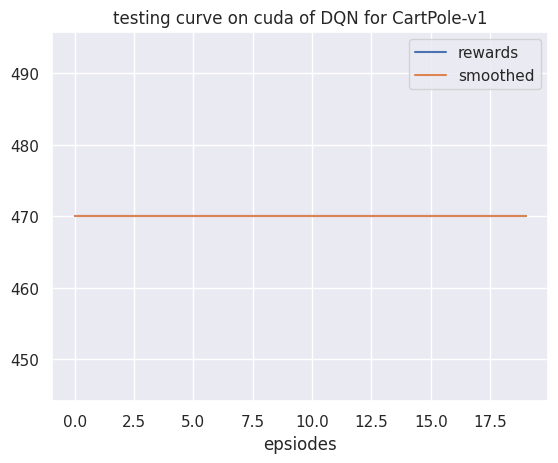

In [10]:
# 获取参数
cfg = get_args() 
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], cfg, tag="train")  
# 测试
res_dic = test_and_record(cfg, agent)
plot_rewards(res_dic['rewards'], cfg, tag="test")  # 画出结果